In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
from sklearn.model_selection import KFold
import logging
from tqdm import tqdm

# Configure logging
logging.basicConfig(filename='pipeline.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# ====================== Path Configuration ==========================
BASE_DIR = r"C:\Users\mitta\OneDrive\Desktop\pbl enhanced\chest_xray"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")
PREPROCESSED_DIR = r"C:\Users\mitta\OneDrive\Desktop\pbl enhanced\preprocessed"
ENHANCED_DIR = r"C:\Users\mitta\OneDrive\Desktop\pbl enhanced\enhanced_image"

os.makedirs(PREPROCESSED_DIR, exist_ok=True)
os.makedirs(ENHANCED_DIR, exist_ok=True)

# ====================== Data Analysis Functions =====================
def count_images(directory):
    """Count number of images in NORMAL and PNEUMONIA categories with error handling."""
    categories = ["NORMAL", "PNEUMONIA"]
    counts = {}
    for cat in categories:
        try:
            cat_path = os.path.join(directory, cat)
            if os.path.exists(cat_path):
                counts[cat] = len([f for f in os.listdir(cat_path) if f.endswith(('.jpg', '.jpeg', '.png'))])
            else:
                counts[cat] = 0
                logging.warning(f"Directory not found: {cat_path}")
        except Exception as e:
            logging.error(f"Error counting images in {cat_path}: {str(e)}")
            counts[cat] = 0
    return counts

def plot_class_distributions():
    """Plot class distributions across train, val, and test sets."""
    sets = {'Train': TRAIN_DIR, 'Validation': VAL_DIR, 'Test': TEST_DIR}
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (name, path) in enumerate(sets.items()):
        counts = count_images(path)
        if counts:
            sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax[i])
            ax[i].set_title(f"{name} Set (Total: {sum(counts.values())})")
            ax[i].set_ylabel("Number of Images")
            
            # Add percentage annotations
            total = sum(counts.values())
            for j, v in enumerate(counts.values()):
                ax[i].text(j, v + 5, f"{v/total:.1%}", ha='center')
    
    plt.tight_layout()
    plt.savefig('class_distributions.png')
    plt.show()

# ====================== Image Preprocessing =========================
def get_transform(augment=False):
    """Return preprocessing transform with optional augmentation."""
    base_transform = [
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.0], std=[1.0])
    ]
    
    if augment:
        base_transform.insert(2, transforms.RandomHorizontalFlip())
        base_transform.insert(2, transforms.RandomRotation(10))
    
    return transforms.Compose(base_transform)

def preprocess_and_save_images(input_dir, output_dir):
    """Preprocess and save each image to output_dir with error handling."""
    transform = get_transform()
    os.makedirs(output_dir, exist_ok=True)
    
    for category in ["NORMAL", "PNEUMONIA"]:
        category_input = os.path.join(input_dir, category)
        category_output = os.path.join(output_dir, category)
        os.makedirs(category_output, exist_ok=True)
        
        # Get image list with progress bar
        image_files = [f for f in os.listdir(category_input) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_name in tqdm(image_files, desc=f"Processing {category}"):
            try:
                img_path = os.path.join(category_input, img_name)
                img = Image.open(img_path).convert("RGB")
                
                # Skip corrupted images
                if img is None:
                    logging.warning(f"Failed to load image: {img_path}")
                    continue
                
                tensor_img = transform(img)
                img_np = tensor_img.squeeze().numpy() * 255
                img_np = img_np.astype(np.uint8)
                
                save_path = os.path.join(category_output, img_name)
                cv2.imwrite(save_path, img_np)
                
            except Exception as e:
                logging.error(f"Error processing {img_path}: {str(e)}")
                continue

# ====================== Image Enhancement ===========================
def apply_clahe(image_np):
    """Apply CLAHE for local contrast enhancement with error handling."""
    try:
        if len(image_np.shape) == 3:
            image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image_np)
    except Exception as e:
        logging.error(f"CLAHE enhancement failed: {str(e)}")
        return image_np

def enhance_images(input_dir, output_dir):
    """Enhance each image using CLAHE and save it with error handling."""
    os.makedirs(output_dir, exist_ok=True)
    
    for category in ["NORMAL", "PNEUMONIA"]:
        input_path = os.path.join(input_dir, category)
        output_path = os.path.join(output_dir, category)
        os.makedirs(output_path, exist_ok=True)
        
        image_files = [f for f in os.listdir(input_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for img_name in tqdm(image_files, desc=f"Enhancing {category}"):
            try:
                img_path = os.path.join(input_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    logging.warning(f"Failed to load image for enhancement: {img_path}")
                    continue
                
                enhanced = apply_clahe(img)
                save_path = os.path.join(output_path, img_name)
                cv2.imwrite(save_path, enhanced)
                
            except Exception as e:
                logging.error(f"Error enhancing {img_path}: {str(e)}")
                continue

# ====================== Dataset Class ===============================
class ChestXrayDataset(Dataset):
    """PyTorch Dataset class for chest X-ray images with caching."""
    def __init__(self, directory, transform=None, cache=True):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        self.cache = cache
        self.cached_images = {}
        
        # Map categories to numerical labels
        self.class_to_idx = {"NORMAL": 0, "PNEUMONIA": 1}
        
        for category in self.class_to_idx.keys():
            cat_dir = os.path.join(directory, category)
            if not os.path.exists(cat_dir):
                logging.warning(f"Directory not found: {cat_dir}")
                continue
                
            for img_name in os.listdir(cat_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(cat_dir, img_name))
                    self.labels.append(self.class_to_idx[category])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        if idx in self.cached_images and self.cache:
            return self.cached_images[idx]
        
        img_path = self.image_paths[idx]
        try:
            img = Image.open(img_path).convert("RGB")
            
            if self.transform:
                img = self.transform(img)
            
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            
            if self.cache:
                self.cached_images[idx] = (img, label)
                
            return img, label
        except Exception as e:
            logging.error(f"Error loading image {img_path}: {str(e)}")
            # Return a dummy image if loading fails
            dummy_img = torch.zeros((1, 224, 224), dtype=torch.float32)
            return dummy_img, torch.tensor(0, dtype=torch.float32)

# ====================== Loss Function ===============================
class FocalLoss(nn.Module):
    """Enhanced Focal loss for handling class imbalance with auto-alpha."""
    def __init__(self, gamma=2.0, reduction='mean', alpha=None, dataset=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        # Calculate alpha automatically if dataset is provided
        if alpha is None and dataset is not None:
            targets = [label for _, label in dataset]
            class_counts = torch.bincount(torch.stack(targets).long())
            self.alpha = 1 - class_counts / class_counts.sum()
        else:
            self.alpha = alpha if alpha is not None else torch.tensor([0.25, 0.75])
            
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        probs = torch.sigmoid(inputs)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        
        # Expand alpha to match batch size
        alpha_t = self.alpha[0] * (1 - targets) + self.alpha[1] * targets
        
        focal_loss = alpha_t * (1 - p_t) ** self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# ====================== K-Fold Cross Validation =====================
def prepare_kfold_data(n_splits=5):
    """Prepare k-fold cross validation datasets."""
    full_dataset = ChestXrayDataset(TRAIN_DIR, transform=get_transform())
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    folds = []
    for train_idx, val_idx in kfold.split(full_dataset):
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)
        folds.append((train_subset, val_subset))
    
    return folds

# ====================== Visualization Utilities =====================
def visualize_sample_images(directory=TRAIN_DIR, n_samples=3):
    """Visualize sample images from each class with preprocessing comparison."""
    fig, axes = plt.subplots(2, n_samples * 2, figsize=(20, 8))
    
    for i, category in enumerate(["NORMAL", "PNEUMONIA"]):
        cat_dir = os.path.join(directory, category)
        sample_files = [f for f in os.listdir(cat_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:n_samples]
        
        for j, img_name in enumerate(sample_files):
            try:
                # Original image
                img_path = os.path.join(cat_dir, img_name)
                orig_img = Image.open(img_path).convert("RGB")
                axes[i, j].imshow(orig_img)
                axes[i, j].set_title(f"Original {category}")
                axes[i, j].axis('off')
                
                # Preprocessed image
                transform = get_transform()
                proc_img = transform(orig_img).squeeze().numpy()
                axes[i, j + n_samples].imshow(proc_img, cmap='gray')
                axes[i, j + n_samples].set_title(f"Processed {category}")
                axes[i, j + n_samples].axis('off')
            except Exception as e:
                logging.error(f"Error visualizing {img_path}: {str(e)}")
                continue
    
    plt.tight_layout()
    plt.savefig('sample_images.png')
    plt.show()

def plot_pixel_intensity(image_path):
    """Enhanced pixel intensity plot with preprocessing comparison."""
    try:
        img = Image.open(image_path).convert("L")
        transform = get_transform()
        tensor_img = transform(img.convert("RGB"))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Original image histogram
        img_np = np.array(img)
        ax1.hist(img_np.ravel(), bins=50, color='blue', alpha=0.7)
        ax1.set_title("Original Pixel Intensity")
        ax1.set_xlabel("Pixel Value")
        ax1.set_ylabel("Frequency")
        
        # Processed image histogram
        proc_np = tensor_img.squeeze().numpy()
        ax2.hist(proc_np.ravel(), bins=50, color='green', alpha=0.7)
        ax2.set_title("Processed Pixel Intensity")
        ax2.set_xlabel("Normalized Pixel Value")
        
        plt.tight_layout()
        plt.savefig('pixel_intensity_comparison.png')
        plt.show()
    except Exception as e:
        logging.error(f"Error plotting pixel intensity for {image_path}: {str(e)}")

# ====================== Main Workflow ===============================
def main():
    try:
        print("🔍 Analyzing class distributions...")
        plot_class_distributions()

        print("\n🧼 Preprocessing images...")
        preprocess_and_save_images(TRAIN_DIR, os.path.join(PREPROCESSED_DIR, "train"))
        preprocess_and_save_images(VAL_DIR, os.path.join(PREPROCESSED_DIR, "val"))
        preprocess_and_save_images(TEST_DIR, os.path.join(PREPROCESSED_DIR, "test"))

        print("\n⚙️ Enhancing images...")
        enhance_images(os.path.join(PREPROCESSED_DIR, "train"), os.path.join(ENHANCED_DIR, "train"))
        enhance_images(os.path.join(PREPROCESSED_DIR, "val"), os.path.join(ENHANCED_DIR, "val"))
        enhance_images(os.path.join(PREPROCESSED_DIR, "test"), os.path.join(ENHANCED_DIR, "test"))

        print("\n🖼️ Visualizing sample images...")
        visualize_sample_images()

        print("\n📊 Plotting pixel intensity of a sample image...")
        sample_path = os.path.join(TRAIN_DIR, "NORMAL", os.listdir(os.path.join(TRAIN_DIR, "NORMAL"))[0])
        plot_pixel_intensity(sample_path)

        print("\n✅ Pipeline complete. Logs saved to pipeline.log")
        
    except Exception as e:
        logging.critical(f"Pipeline failed: {str(e)}", exc_info=True)
        print(f"❌ Pipeline failed. Check logs for details: {str(e)}")

if __name__ == "__main__":
    main()

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Layer, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [5]:
import random
import numpy as np

# Set seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '69'
random.seed(69)
np.random.seed(69)
tf.random.set_seed(69)


Found 4173 images belonging to 2 classes.
Found 2 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


e:\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 780ms/step - accuracy: 0.6736 - loss: 0.7505 - val_accuracy: 0.5000 - val_loss: 5.8707 - learning_rate: 1.0000e-04
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 72s 550ms/step - accuracy: 0.8199 - loss: 0.4529 - val_accuracy: 0.5000 - val_loss: 1.6110 - learning_rate: 1.0000e-04
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 88s 676ms/step - accuracy: 0.8404 - loss: 0.4176 - val_accuracy: 0.5000 - val_loss: 1.6120 - learning_rate: 1.0000e-04
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 731ms/step - accuracy: 0.8640 - loss: 0.3904 - val_accuracy: 1.0000 - val_loss: 0.1925 - learning_rate: 1.0000e-04
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 96s 728ms/step - accuracy: 0.8672 - loss: 0.3834 - val_accuracy: 0.5000 - val_loss: 1.0400 - learning_rate: 1.0000e-04
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s 796ms/step - accuracy: 0.8970 - loss: 0.3357 - val_accuracy: 1.0000 - val_loss: 0.3033 - learning_rate: 1.0000e-04
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 104s

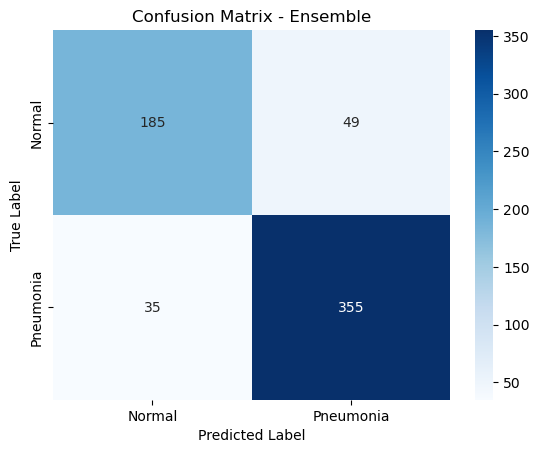

In [ ]:

# ✅ Custom Fuzzy Layer
class FuzzyLayer(Layer):
    def __init__(self, units=1, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(self.units, input_shape[-1]), initializer='uniform', trainable=True)
        self.sigmas = self.add_weight(shape=(self.units, input_shape[-1]), initializer='ones', trainable=True)

    def call(self, inputs):
        inputs_exp = tf.expand_dims(inputs, 1)
        centers_exp = tf.expand_dims(self.centers, 0)
        sigmas_exp = tf.expand_dims(self.sigmas, 0)
        fuzzy_output = tf.exp(-tf.square(inputs_exp - centers_exp) / (2 * tf.square(sigmas_exp)))
        return tf.reduce_sum(fuzzy_output, axis=-1)

# ✅ Data Pipeline
img_size = 224
batch_size = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    fill_mode='nearest',
    validation_split=0.2
)

# Updated paths for enhanced images
enhanced_data_path = r'C:\Users\mitta\OneDrive\Desktop\pbl enhanced\enhanced_image'
train_data = train_gen.flow_from_directory(
    os.path.join(enhanced_data_path, 'train'),  # Path to enhanced train directory
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=batch_size,
    subset='training'
)
val_data = train_gen.flow_from_directory(
    os.path.join(enhanced_data_path, 'val'),  # Path to enhanced train directory
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation'
)

test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(enhanced_data_path, 'test'),  # Path to enhanced test directory
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# ✅ Base Model Wrapper with FuzzyNet Head
def create_fuzzy_model(base_model_class):
    base = base_model_class(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = FuzzyLayer(units=16)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=base.input, outputs=x)

# ✅ Create All Three Models
model_mv2 = create_fuzzy_model(MobileNetV2)
model_resnet = create_fuzzy_model(ResNet50)
model_effnet = create_fuzzy_model(EfficientNetB0)

# ✅ Compile Them
for model in [model_mv2, model_resnet, model_effnet]:
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# ✅ Train Each Model
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
]

model_mv2.fit(train_data, validation_data=val_data, epochs=15, callbacks=callbacks)
model_resnet.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)
model_effnet.fit(train_data, validation_data=val_data, epochs=20, callbacks=callbacks)

# ✅ Soft Voting Ensemble Prediction
y_probs_mv2 = model_mv2.predict(test_data)
y_probs_res = model_resnet.predict(test_data)
y_probs_eff = model_effnet.predict(test_data)

ensemble_probs = (3 * y_probs_mv2 + 0.5 * y_probs_res + 1* y_probs_eff) / (3+0.5+1)
y_pred = (ensemble_probs > 0.5).astype(int)

# ✅ Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_data.classes
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix - Ensemble")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()































In [8]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class FuzzyLayer(Layer):
    def __init__(self, units=1, **kwargs):
        super(FuzzyLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.centers = self.add_weight(shape=(self.units, input_shape[-1]), 
                                     initializer='uniform', 
                                     trainable=True)
        self.sigmas = self.add_weight(shape=(self.units, input_shape[-1]), 
                                    initializer='ones', 
                                    trainable=True)

    def call(self, inputs):
        inputs_exp = tf.expand_dims(inputs, 1)
        centers_exp = tf.expand_dims(self.centers, 0)
        sigmas_exp = tf.expand_dims(self.sigmas, 0)
        fuzzy_output = tf.exp(-tf.square(inputs_exp - centers_exp) / (2 * tf.square(sigmas_exp)))
        return tf.reduce_sum(fuzzy_output, axis=-1)

    def get_config(self):
        config = super(FuzzyLayer, self).get_config()
        config.update({'units': self.units})
        return config

In [10]:
# Save the model (use .keras extension recommended)
model_mv2.save('fuzzy_model_mv2.keras')  # or .h5 format
model_resnet.save('fuzzy_model_resnet.keras')
model_effnet.save('fuzzy_model_effnet.keras')

In [9]:
# To load the models later
loaded_mv2 = tf.keras.models.load_model('fuzzy_model_mv2.keras', 
                                      custom_objects={'FuzzyLayer': FuzzyLayer})
loaded_resnet = tf.keras.models.load_model('fuzzy_model_resnet.keras', 
                                        custom_objects={'FuzzyLayer': FuzzyLayer})
loaded_effnet = tf.keras.models.load_model('fuzzy_model_effnet.keras', 
                                        custom_objects={'FuzzyLayer': FuzzyLayer})

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2



from tensorflow.keras.preprocessing import image
import joblib

# Define the path to your enhanced images
ENHANCED_IMAGE_PATH = r'C:\Users\mitta\OneDrive\Desktop\pbl enhanced\enhanced_image'
def get_img_array(img_path, size):
    """Load and preprocess image"""
    img = image.load_img(img_path, target_size=size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array / 255.

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Generate Grad-CAM heatmap"""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_output = predictions[:, pred_index]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name, img_size=(224, 224)):
    """Display Grad-CAM only if pneumonia is predicted"""
    img_array = get_img_array(img_path, img_size)
    
    # Make prediction first
    pred = model.predict(img_array)[0][0]
    confidence = pred if pred > 0.5 else (1 - pred)
    
    # Only proceed if pneumonia is predicted with confidence > 50%
    if pred > 0.5:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

        superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)

        # Show the image with label
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pneumonia Detected ({pred*100:.2f}% confidence)", fontsize=16)
        plt.axis('off')
        plt.show()
    else:
        print(f"Normal case detected ({(1-pred)*100:.2f}% confidence). No visualization shown.")

# Example usage:
# Load your trained model (replace with your actual model loading code)
# model = tf.keras.models.load_model('your_model_path.h5')

# Define the last convolutional layer name for each model
last_conv_layers = {
    'MobileNetV2': 'out_relu',  # Typical last conv layer for MobileNetV2
    'ResNet50': 'conv5_block3_out',  # For ResNet50
    'EfficientNetB0': 'top_activation'  # For EfficientNetB0
}

# Choose which model to visualize (change as needed)
model_name = 'MobileNetV2'  # or 'ResNet50' or 'EfficientNetB0'
last_conv_layer_name = last_conv_layers[model_name]

# Path to a test image (replace with your actual image path)
test_image_path = r"C:\Users\mitta\OneDrive\Desktop\pbl enhanced\enhanced_image\test\PNEUMONIA\person1_virus_6.jpeg"

# Run visualization (only shows output if pneumonia is predicted)
display_gradcam(test_image_path, model, last_conv_layer_name)
# display_gradcam(test_image_path, model_resnet, last_conv_layer_name)
# display_gradcam(test_image_path, model_effnet, last_conv_layer_name)# Using model_mv2 from previous code

In [18]:
# ✅ Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

enhanced_data_path = r'C:\Users\mitta\OneDrive\Desktop\pbl enhanced\enhanced_image'
img_size = 224
batch_size = 32
test_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(enhanced_data_path, 'test'),  # Path to enhanced test directory
    target_size=(img_size, img_size),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# ✅ Soft Voting Ensemble Prediction
y_probs_mv2 = loaded_mv2.predict(test_data)
y_probs_res = loaded_resnet.predict(test_data)
y_probs_eff = loaded_effnet.predict(test_data)

Found 624 images belonging to 2 classes.


e:\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step
